In [1]:
import numpy as np

import proper
import roman_phasec_proper

import ray # for multiprocesing
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
reload(cgi)

import misc_funs as misc

npix = 310

iwa = 2.8
owa = 9.7

dm1_flat = fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

dm1_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm1.fits')
dm2_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [11]:
wf.shape

(64,)

Propagating wavelength 575.000 nm.
PSF calculated in 12.283s


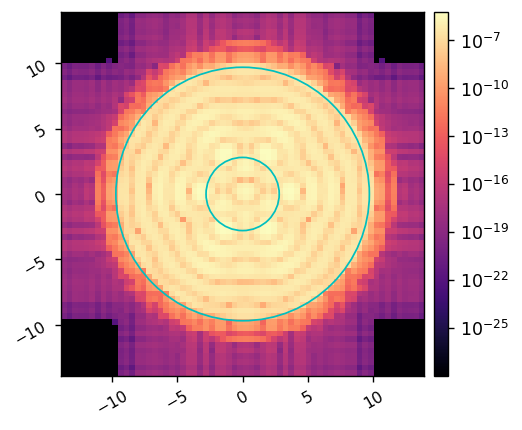

In [2]:
reload(cgi)
reload(cgi.proper_cgi)
mode = cgi.PROPERCGI(cgi_mode='hlc', 
                     use_pupil_defocus=True, 
                     use_opds=False,
                     polaxis=0)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)


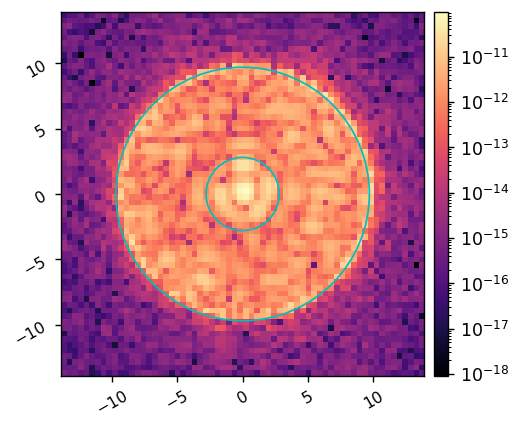

In [3]:
mode = cgi.PROPERCGI(cgi_mode='hlc', 
                     use_pupil_defocus=True, 
                     use_opds=True,
                     polaxis=10)

mode.set_dm1(dm1_best)
mode.set_dm2(dm2_best)

# wf = mode.calc_psf(quiet=False)
# psf = np.abs(wf)**2

psf = mode.snap()

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)


In [2]:
reload(cgi)
reload(cgi.proper_cgi)
reload(cgi.multi_cgi)

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

npol = 4
polaxis = np.array([-2, -1, 1, 2])

mode_settings = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,    
    'use_opds':True,
}

In [3]:
rayCGI = ray.remote(cgi.PROPERCGI)

actors = []
for i in range(nlam):
    for j in range(npol):
        actors.append(rayCGI.options(num_cpus=2).remote(wavelength=wavelengths[i],
                                                        polaxis=polaxis[j], 
                                                        **mode_settings))


In [4]:
# from cgi import multiCGI

hlc = cgi.multiCGI(actors)

hlc.set_dm1(dm1_best)
hlc.set_dm2(dm2_best)

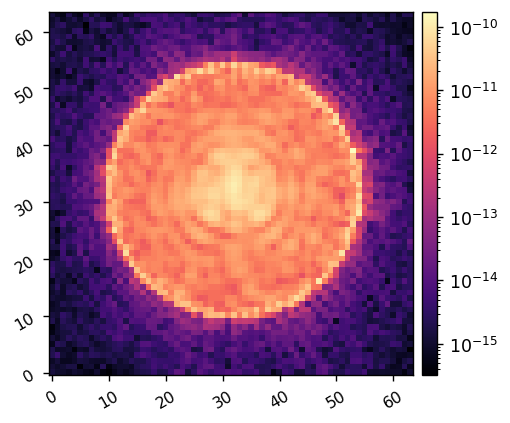

In [5]:
im = hlc.snap()
misc.imshow1(im, lognorm=True)

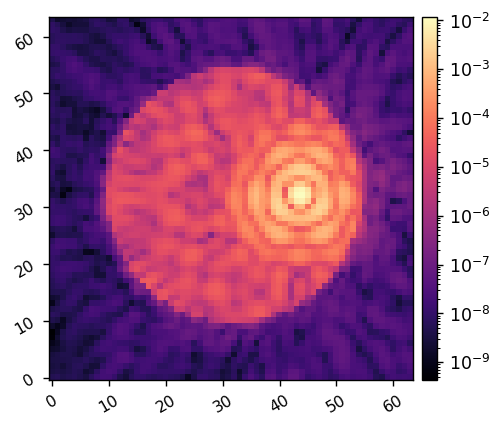

In [6]:
hlc.source_offset((5,0))
im = hlc.snap()
misc.imshow1(im, lognorm=True)

In [6]:
def snap_all(actors, plot=False, return_all=True):
    pending_ims = []
    for i in range(len(actors)):
        actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
        actors[i].set_dm2.remote(dm2_flat)
        
        future_ims = actors[i].snap.remote()
        pending_ims.append(future_ims)
    ims = np.array(ray.get(pending_ims))
    
    im = np.sum(ims, axis=0)/len(actors) # average each of the images 
    
    clear_output(wait=True)
    if plot:
        for i in range(len(actors)):
            misc.imshow1(ims[i], lognorm=True,)
            
    if return_all:
        return im, ims
    else:
        return im

In [5]:
im, ims = snap_all(actors, plot=True)

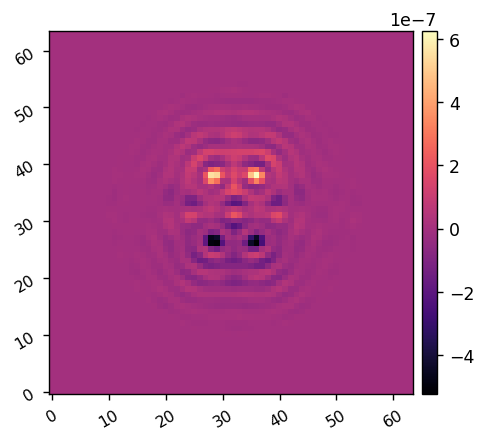

In [7]:
misc.imshow1(ims[0]-ims[1])